In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary
from PIL import Image
from torch.optim.lr_scheduler import StepLR

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/batches.meta
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/readme.html


In [3]:
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

# Specify the folder where the CIFAR-10 batch files are
cifar10_dir = '/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'

# Load the label names
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = meta_data_dict[b'label_names']

train_images = []
train_labels = []
data_batches = ['data_batch_1', 'data_batch_2', 'data_batch_3', 'data_batch_4', 'data_batch_5']
for batch in data_batches:
    # Load one batch for demonstration (e.g., data_batch_1)
    batch_dict = load_cifar_batch(os.path.join(cifar10_dir, batch))
    train_images.append(batch_dict[b'data'])
    train_labels.append(batch_dict[b'labels'])

train_images = np.concatenate((train_images[0], train_images[1], train_images[2], train_images[3], train_images[4]))
train_labels = np.concatenate((train_labels[0], train_labels[1], train_labels[2], train_labels[3], train_labels[4]))

# Reshape the images
train_images = train_images.reshape((50000, 3, 32, 32)).transpose(0, 2, 3, 1)

def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        batch = pickle.load(fo, encoding='bytes')
    return batch

# Load the batch
cifar10_batch = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl')

# Extract images 
test_images = cifar10_batch[b'data']

test_images = test_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

validation_data = load_cifar_batch('/kaggle/input/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py/test_batch')

validation_images = validation_data[b'data']
validation_labels = validation_data[b'labels']

validation_images = validation_images.reshape((10000, 3, 32, 32)).transpose(0, 2, 3, 1)

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Randomly crop the image
    transforms.RandomHorizontalFlip(),      # Randomly flip the image horizontally
    transforms.RandomRotation(10),          # Randomly rotate the image by 10 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Randomly change color
    transforms.ToTensor()                  # Convert image to Tensor
])


train_dataset = [(transform(Image.fromarray(img)), label) for img, label in zip(train_images, train_labels)]
validation_dataset = [(transform(Image.fromarray(img)), label) for img, label in zip(validation_images, validation_labels)]

trainDataLoader = torch.utils.data.DataLoader(train_dataset,batch_size=128,shuffle=True)

validationDataLoader = torch.utils.data.DataLoader(validation_dataset,batch_size=128,shuffle=True)

testDataLoader = torch.utils.data.DataLoader(test_images,batch_size=128,shuffle=False)

In [4]:
class BuildingBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BuildingBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.skip = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.skip = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.conv2(out)
        out = self.bn2(out)  
        out += self.skip(x) 
        out = self.relu2(out)
        out = self.dropout(out)
        return out


class ResNet(nn.Module):
    
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.output = nn.Linear(256, num_classes)


    def _make_layer(self, block, planes, num_blocks, stride):
        layers = [block(self.in_planes, planes, stride)]
        self.in_planes = planes  # Update input channels
        for _ in range(1, num_blocks):
            layers.append(block(self.in_planes, planes, stride=1))
        return nn.Sequential(*layers)


    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = torch.flatten(out, 1)
        out = self.output(out)
        return out


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = ResNet(BuildingBlock, [3, 3, 3, 3])
model = model.to(device)
summary(model, (3, 32, 32))

from tqdm import tqdm

loss = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

train_loss_history = []
test_loss_history = []

num_epochs = 30

for epoch in tqdm(range(num_epochs)):
  train_loss = 0.0
  test_loss = 0.0

  correct = 0
  total = 0
  model.train()
  for i, data in enumerate(trainDataLoader):
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    optimizer.zero_grad() # zero out any gradient values from the previous iteration
    predicted_output = model(images) # forward propagation
    predicted = torch.argmax(predicted_output, dim=1)
    correct += (predicted == labels).sum().item()  # Count correct predictions
    total += labels.size(0)  # Total number of samples
    fit = loss(predicted_output, labels)  # calculate our measure of goodness
    fit.backward() # backpropagation
    optimizer.step() # update the weights of our trainable parameters
    train_loss += fit.item()

  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Train Accuracy: {accuracy:.2f}%')

  correct = 0
  total = 0
  model.eval()
  for i, data in enumerate(validationDataLoader):
    with torch.no_grad():
      images, labels = data
      images = images.to(device)
      labels = labels.to(device)
      predicted_output = model(images)
      predicted = torch.argmax(predicted_output, dim=1)
      correct += (predicted == labels).sum().item()  # Count correct predictions
      total += labels.size(0)  # Total number of samples
      fit = loss(predicted_output, labels)
      test_loss += fit.item()
  train_loss = train_loss / len(trainDataLoader)
  test_loss = test_loss / len(testDataLoader)
  train_loss_history += [train_loss]
  test_loss_history += [test_loss]
  accuracy = 100 * correct / total  # Compute accuracy percentage
  print(f'Test Accuracy: {accuracy:.2f}%')
  print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')

  scheduler.step()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
            Conv2d-6           [-1, 32, 32, 32]           9,216
       BatchNorm2d-7           [-1, 32, 32, 32]              64
              ReLU-8           [-1, 32, 32, 32]               0
           Dropout-9           [-1, 32, 32, 32]               0
    BuildingBlock-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
           Conv2d-14           [-1, 32,

  0%|          | 0/30 [00:00<?, ?it/s]

Train Accuracy: 30.63%


  3%|▎         | 1/30 [00:27<13:14, 27.41s/it]

Test Accuracy: 28.65%
Epoch 0, Train loss 1.8598222567907075, Test loss 2.302290261546268
Train Accuracy: 44.68%


  7%|▋         | 2/30 [00:54<12:49, 27.47s/it]

Test Accuracy: 28.54%
Epoch 1, Train loss 1.5046404953807822, Test loss 2.5068922405001484
Train Accuracy: 52.44%


 10%|█         | 3/30 [01:23<12:30, 27.80s/it]

Test Accuracy: 50.60%
Epoch 2, Train loss 1.3093861746970954, Test loss 1.494077919404718
Train Accuracy: 57.70%


 13%|█▎        | 4/30 [01:52<12:15, 28.30s/it]

Test Accuracy: 56.19%
Epoch 3, Train loss 1.1708923354173255, Test loss 1.2990110327925863
Train Accuracy: 61.50%


 17%|█▋        | 5/30 [02:22<12:02, 28.89s/it]

Test Accuracy: 61.70%
Epoch 4, Train loss 1.0802256335382876, Test loss 1.141235693346096
Train Accuracy: 64.27%


 20%|██        | 6/30 [02:51<11:39, 29.13s/it]

Test Accuracy: 64.01%
Epoch 5, Train loss 1.0058314108177828, Test loss 1.0401568163799335
Train Accuracy: 66.40%


 23%|██▎       | 7/30 [03:21<11:13, 29.26s/it]

Test Accuracy: 65.42%
Epoch 6, Train loss 0.943485138818736, Test loss 1.0213693485984319
Train Accuracy: 68.68%


 27%|██▋       | 8/30 [03:50<10:47, 29.41s/it]

Test Accuracy: 67.98%
Epoch 7, Train loss 0.8851275956234359, Test loss 0.9144271234922772
Train Accuracy: 70.42%


 30%|███       | 9/30 [04:20<10:19, 29.50s/it]

Test Accuracy: 71.81%
Epoch 8, Train loss 0.8377607574548258, Test loss 0.8125004489210588
Train Accuracy: 72.18%


 33%|███▎      | 10/30 [04:50<09:51, 29.56s/it]

Test Accuracy: 71.48%
Epoch 9, Train loss 0.7863261027409293, Test loss 0.838254650936851
Train Accuracy: 73.63%


 37%|███▋      | 11/30 [05:20<09:22, 29.60s/it]

Test Accuracy: 71.13%
Epoch 10, Train loss 0.747097410356907, Test loss 0.8562962865527672
Train Accuracy: 75.00%


 40%|████      | 12/30 [05:49<08:53, 29.61s/it]

Test Accuracy: 74.50%
Epoch 11, Train loss 0.713075758855971, Test loss 0.7473820455466644
Train Accuracy: 76.16%


 43%|████▎     | 13/30 [06:19<08:23, 29.62s/it]

Test Accuracy: 75.21%
Epoch 12, Train loss 0.6807167642104351, Test loss 0.7201399746574934
Train Accuracy: 77.06%


 47%|████▋     | 14/30 [06:49<07:54, 29.63s/it]

Test Accuracy: 76.47%
Epoch 13, Train loss 0.657015055265573, Test loss 0.6957649498046199
Train Accuracy: 77.85%


 50%|█████     | 15/30 [07:18<07:24, 29.62s/it]

Test Accuracy: 75.41%
Epoch 14, Train loss 0.6298918765981484, Test loss 0.7261304395108283
Train Accuracy: 78.74%


 53%|█████▎    | 16/30 [07:48<06:54, 29.61s/it]

Test Accuracy: 75.14%
Epoch 15, Train loss 0.6016234578683858, Test loss 0.7562133601949185
Train Accuracy: 79.51%


 57%|█████▋    | 17/30 [08:17<06:24, 29.61s/it]

Test Accuracy: 76.25%
Epoch 16, Train loss 0.5820254970846883, Test loss 0.7182159582270852
Train Accuracy: 80.28%


 60%|██████    | 18/30 [08:47<05:55, 29.61s/it]

Test Accuracy: 76.37%
Epoch 17, Train loss 0.5638922521525331, Test loss 0.7112129398539097
Train Accuracy: 81.27%


 63%|██████▎   | 19/30 [09:17<05:25, 29.62s/it]

Test Accuracy: 78.68%
Epoch 18, Train loss 0.53673244307718, Test loss 0.645703511524804
Train Accuracy: 81.65%


 67%|██████▋   | 20/30 [09:46<04:56, 29.65s/it]

Test Accuracy: 77.96%
Epoch 19, Train loss 0.5174813073157044, Test loss 0.6880183808411224
Train Accuracy: 82.10%


 70%|███████   | 21/30 [10:16<04:27, 29.67s/it]

Test Accuracy: 77.01%
Epoch 20, Train loss 0.503443809726354, Test loss 0.7153499945055081
Train Accuracy: 82.64%


 73%|███████▎  | 22/30 [10:46<03:57, 29.68s/it]

Test Accuracy: 78.63%
Epoch 21, Train loss 0.4892525021987193, Test loss 0.652841747184343
Train Accuracy: 83.11%


 77%|███████▋  | 23/30 [11:15<03:27, 29.70s/it]

Test Accuracy: 78.30%
Epoch 22, Train loss 0.47491546886046526, Test loss 0.6527706290347667
Train Accuracy: 83.77%


 80%|████████  | 24/30 [11:45<02:58, 29.70s/it]

Test Accuracy: 80.26%
Epoch 23, Train loss 0.45871664351209657, Test loss 0.5933988320676586
Train Accuracy: 84.31%


 83%|████████▎ | 25/30 [12:15<02:28, 29.68s/it]

Test Accuracy: 79.70%
Epoch 24, Train loss 0.4442246871836045, Test loss 0.6223338023771213
Train Accuracy: 84.75%


 87%|████████▋ | 26/30 [12:44<01:58, 29.68s/it]

Test Accuracy: 80.51%
Epoch 25, Train loss 0.43240403042882297, Test loss 0.6222337688071818
Train Accuracy: 85.15%


 90%|█████████ | 27/30 [13:14<01:28, 29.65s/it]

Test Accuracy: 80.26%
Epoch 26, Train loss 0.4188008561463612, Test loss 0.631026747860486
Train Accuracy: 85.63%


 93%|█████████▎| 28/30 [13:44<00:59, 29.64s/it]

Test Accuracy: 81.03%
Epoch 27, Train loss 0.40438040900413336, Test loss 0.589880816166914
Train Accuracy: 85.84%


 97%|█████████▋| 29/30 [14:13<00:29, 29.63s/it]

Test Accuracy: 81.35%
Epoch 28, Train loss 0.4005399459539472, Test loss 0.5858466960961306
Train Accuracy: 86.54%


100%|██████████| 30/30 [14:43<00:00, 29.45s/it]

Test Accuracy: 81.59%
Epoch 29, Train loss 0.3799020215068632, Test loss 0.5869624790134309


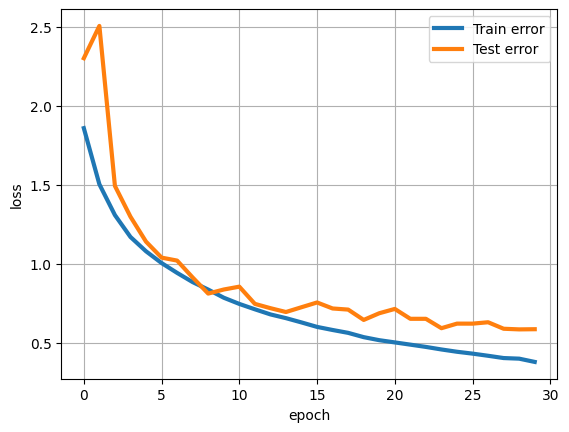

In [8]:
plt.plot(range(30),train_loss_history,'-',linewidth=3,label='Train error')
plt.plot(range(30),test_loss_history,'-',linewidth=3,label='Test error')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
model.eval()
predictions = []
with torch.no_grad():
    for images in testDataLoader:
        images = images.to(device)
        images = torch.tensor(images, dtype=torch.float32)  # Convert NumPy array to PyTorch tensor
        images = images.permute(0, 3, 1, 2)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())

submission = pd.DataFrame({'ID': np.arange(len(predictions)), 'Labels': predictions})
submission.to_csv('/kaggle/working/submission.csv', index=False)
print("Submission file saved.")

In [ ]:
torch.save(model.state_dict(), "model_weights.pth")